In [200]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from category_encoders import TargetEncoder

In [321]:
df_labeled=pd.read_csv("../Processed Data/prd_loyal_customers.csv")
df_labeled.drop(columns=['is_repeat_customer', 'is_repeat_customer', 'days_since_last_order','is_first_order'], inplace=True)

In [316]:
df_labeled.head()

,customer_id,order_id,order_purchase_timestamp,snapshot_date,past_order_count,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,tot_customers_in_zip,tot_sellers_in_zip,geolocation_lat,geolocation_lng,is_latlng_missing,n_distinct_categories,main_category,avg_photos_per_product,avg_desc_length,avg_weight,avg_volume,max_weight,max_volume,total_price,min_price,max_price,avg_price,total_freight_value,avg_freight_value,total_order_value,avg_order_value,min_order_value,max_order_value,total_items,min_items,max_items,review_count,avg_review_score,avg_review_length,has_review_text,min_review_score,max_review_score,pymt_mode_boleto,pymt_mode_credit_card,pymt_mode_debit_card,pymt_mode_not_defined,pymt_mode_voucher,avg_payment_installments,total_payment_installments,total_payment_value,label_is_loyal
0,fadbb3709178fc513abc1b2670aa1ad2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,2018-05-09 10:56:27,0,0000366f3b9a7992bf8c76cfdf3221e2,7787,cajamar,SP,8.0,0.0,-23.348433,-46.826739,0,1.0,bed_bath_table,1.0,236.0,1500.0,7616.0,1500.0,7616.0,129.90,129.90,129.90,129.90,12.00,12.00,141.90,141.90,141.90,141.90,1.0,1.0,1.0,1.0,5.0,111.0,1.0,5.0,5.0,0.0,141.90,0.0,0.0,0.0,8.0,8.0,141.90,0
1,4cb282e167ae9234755102258dd52ee8,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,2018-05-06 11:11:27,0,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,osasco,SP,9.0,0.0,-23.557203,-46.782778,0,1.0,health_beauty,1.0,635.0,375.0,5148.0,375.0,5148.0,18.90,18.90,18.90,18.90,8.29,8.29,27.19,27.19,27.19,27.19,1.0,1.0,1.0,1.0,4.0,NaN,0.0,4.0,4.0,0.0,27.19,0.0,0.0,0.0,1.0,1.0,27.19,0
2,9b3932a6253894a02c1df9d19004239f,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,2017-03-09 21:05:03,0,0000f46a3911fa3c0805444483337064,88115,sao jose,SC,7.0,1.0,-27.543787,-48.625680,0,1.0,stationery,3.0,177.0,1500.0,43750.0,1500.0,43750.0,69.00,69.00,69.00,69.00,17.22,17.22,86.22,86.22,86.22,86.22,1.0,1.0,1.0,1.0,3.0,NaN,0.0,3.0,3.0,0.0,86.22,0.0,0.0,0.0,8.0,8.0,86.22,0
3,914991f0c02ef0843c0e7010c819d642,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,2017-10-11 20:29:41,0,0000f6ccb0745a6a4b88665a16c9f078,66812,belem,PA,7.0,0.0,-1.310593,-48.488881,0,1.0,telephony,5.0,1741.0,150.0,1045.0,150.0,1045.0,25.99,25.99,25.99,25.99,17.63,17.63,43.62,43.62,43.62,43.62,1.0,1.0,1.0,1.0,4.0,12.0,1.0,4.0,4.0,0.0,43.62,0.0,0.0,0.0,4.0,4.0,43.62,0
4,47227568b10f5f58a524a75507e6992c,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,2017-11-13 19:45:42,0,0004aac84e0df4da2b147fca70cf8255,18040,sorocaba,SP,14.0,3.0,-23.506751,-47.470592,0,1.0,telephony,3.0,794.0,6050.0,528.0,6050.0,528.0,180.00,180.00,180.00,180.00,16.89,16.89,196.89,196.89,196.89,196.89,1.0,1.0,1.0,1.0,5.0,NaN,0.0,5.0,5.0,0.0,196.89,0.0,0.0,0.0,6.0,6.0,196.89,0


In [322]:
df = df_labeled.copy()
df["snapshot_date"] = pd.to_datetime(df["snapshot_date"], errors="coerce")
split_point = df["snapshot_date"].quantile(0.8)

train_idx = df["snapshot_date"] < split_point
test_idx  = df["snapshot_date"] >= split_point

In [323]:
score = df["avg_review_score"].fillna(-1)
length = df["avg_review_length"].fillna(0)

conditions = [
    (score >= 4) & (length > 0),                    # 5: Vocal Promoter
    (score >= 4) & (length == 0),                   # 4: Silent Satisfied
    (score == -1),                                  # 3: Ghost
    (score > 2) & (score < 4),                      # 2: Passive
    (score <= 2) & (score > 0) & (length == 0),     # 1: Quiet Detractor
    (score <= 2) & (score > 0) & (length > 0)       # 0: Vocal Detractor
]
choices = [5, 4, 3, 2, 1, 0]

df["sentiment_index"] = np.select(conditions, choices, default=3).astype(int)

# You can drop raw length if you want
df = df.drop(columns=["avg_review_length"], errors="ignore")


In [324]:
df["main_category"] = df["main_category"].fillna("unknown").astype(str)

state_lookup = df.loc[train_idx].groupby("customer_state")["total_order_value"].mean()
cat_lookup   = df.loc[train_idx].groupby("main_category")["total_order_value"].mean()
global_avg   = df.loc[train_idx, "total_order_value"].mean()

df["state_avg"] = df["customer_state"].map(state_lookup).fillna(global_avg)
df["cat_avg"]   = df["main_category"].map(cat_lookup).fillna(global_avg)

df["value_ratio"]           = df["total_order_value"] / df["state_avg"]
df["val_ratio_vs_category"] = df["total_order_value"] / df["cat_avg"]
df["freight_ordervalue_ratio"] = df["total_freight_value"] / df["total_order_value"].replace(0, np.nan)


In [326]:
eps = 1e-6

df["price_spread_ratio"]      = df["max_price"] / (df["min_price"] + eps)
df["order_value_spread_ratio"]= df["max_order_value"] / (df["min_order_value"] + eps)

df["weight_spread_ratio"]     = df["max_weight"] / (df["avg_weight"] + eps)   # since no min_weight
df["volume_spread_ratio"]     = df["max_volume"] / (df["avg_volume"] + eps)


In [ ]:
for c in ["price_spread_ratio","order_value_spread_ratio","weight_spread_ratio","volume_spread_ratio"]:
    df[c] = df[c].clip(upper=50)  


In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94990 entries, 0 to 94989
Data columns (total 59 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customer_id                 94990 non-null  object        
 1   order_id                    94990 non-null  object        
 2   order_purchase_timestamp    94990 non-null  object        
 3   snapshot_date               94990 non-null  datetime64[ns]
 4   past_order_count            94990 non-null  int64         
 5   customer_unique_id          94990 non-null  object        
 6   customer_zip_code_prefix    94990 non-null  int64         
 7   customer_city               94990 non-null  object        
 8   customer_state              94990 non-null  object        
 9   tot_customers_in_zip        94990 non-null  float64       
 10  tot_sellers_in_zip          94990 non-null  float64       
 11  geolocation_lat             94990 non-null  float64   

In [333]:
# List of columns to drop
drop_cols = [
    'label_is_loyal',           
    'customer_id', 'order_id', 'customer_unique_id',
    'order_purchase_timestamp', 'snapshot_date',    
    'past_order_count',        
    'customer_city',           
    'min_price', 'max_price',  
    'min_order_value', 'max_order_value',
    'max_weight', 'max_volume', 
    'min_review_score', 'max_review_score', 
    'geolocation_lat', 'geolocation_lng', "is_latlng_missing","customer_state"
]


X = df.drop(columns=drop_cols, errors='ignore')
y = df['label_is_loyal']


print(X.select_dtypes(include=['object']).columns)

Index(['main_category'], dtype='object')


In [343]:
import pandas as pd

# 1. Force conversion to datetime immediately
df_labeled["snapshot_date"] = pd.to_datetime(df_labeled["snapshot_date"], errors="coerce")

# 2. Sort chronologically
df = df_labeled.sort_values("snapshot_date").copy()

# 3. Define the Cutoffs based on actual dates
# 80th percentile for the Final Test set
test_cutoff = df["snapshot_date"].quantile(0.8)
# 60th percentile for the Validation set
val_cutoff = df["snapshot_date"].quantile(0.6)

# 4. Assign Indices
train_idx = df["snapshot_date"] < val_cutoff
val_idx   = (df["snapshot_date"] >= val_cutoff) & (df["snapshot_date"] < test_cutoff)
test_idx  = df["snapshot_date"] >= test_cutoff

# 5. Create the Sets
X_train, y_train = X[train_idx].copy(), y[train_idx].copy()
X_val,   y_val   = X[val_idx].copy(),   y[val_idx].copy()
X_test,  y_test  = X[test_idx].copy(),  y[test_idx].copy()

print(f"Training Range: {df.loc[train_idx, 'snapshot_date'].min()} to {df.loc[train_idx, 'snapshot_date'].max()}")
print(f"Test Range:     {df.loc[test_idx, 'snapshot_date'].min()} to {df.loc[test_idx, 'snapshot_date'].max()}")

Training Range: 2016-09-03 21:15:19 to 2018-03-01 13:34:44
Test Range:     2018-05-23 18:04:31 to 2018-08-28 15:00:37


/var/folders/jr/cx9v05mj76767q_pxc111nvr0000gn/T/ipykernel_44503/2552640674.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train, y_train = X[train_idx].copy(), y[train_idx].copy()
/var/folders/jr/cx9v05mj76767q_pxc111nvr0000gn/T/ipykernel_44503/2552640674.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val,   y_val   = X[val_idx].copy(),   y[val_idx].copy()
/var/folders/jr/cx9v05mj76767q_pxc111nvr0000gn/T/ipykernel_44503/2552640674.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test,  y_test  = X[test_idx].copy(),  y[test_idx].copy()


In [ ]:
from category_encoders import TargetEncoder



te = TargetEncoder(cols=["main_category"], smoothing=5)



X_train["main_category"] = te.fit_transform(X_train["main_category"], y_train)



X_val["main_category"] = te.transform(X_val["main_category"])
X_test["main_category"] = te.transform(X_test["main_category"])


X_train["main_category"] = X_train["main_category"].fillna(y_train.mean())
X_val["main_category"]   = X_val["main_category"].fillna(y_train.mean())
X_test["main_category"]  = X_test["main_category"].fillna(y_train.mean())

In [345]:
print("Loyalty score for top categories in Train:")
print(X_train["main_category"].value_counts().head())

Loyalty score for top categories in Train:
main_category
0.061299    5514
0.049468    4609
0.041834    4470
0.041250    3903
0.058486    3830
Name: count, dtype: int64


In [348]:
import xgboost as xgb
from sklearn.metrics import average_precision_score

# 1. Recalculate the imbalance ratio (if not already done)
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
spw = neg_count / pos_count

# 2. Initialize with early_stopping_rounds INSIDE the constructor
model = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=spw,
    objective='binary:logistic',
    eval_metric='aucpr',
    # --- Move early_stopping_rounds here ---
    early_stopping_rounds=50, 
    random_state=42,
    tree_method='hist'
)

# 3. Fit the model (pass the eval_set as before, but remove early_stopping_rounds)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# 4. Final Evaluation
y_probs = model.predict_proba(X_test)[:, 1]
final_pr_auc = average_precision_score(y_test, y_probs)

print(f"\nFinal PR-AUC on Hold-out Test Set: {final_pr_auc:.4f}")

[0]	validation_0-aucpr:0.05355
[1]	validation_0-aucpr:0.05496
[2]	validation_0-aucpr:0.05626
[3]	validation_0-aucpr:0.05727
[4]	validation_0-aucpr:0.05591
[5]	validation_0-aucpr:0.05626
[6]	validation_0-aucpr:0.05673
[7]	validation_0-aucpr:0.05384
[8]	validation_0-aucpr:0.05353
[9]	validation_0-aucpr:0.05341
[10]	validation_0-aucpr:0.05306
[11]	validation_0-aucpr:0.05362
[12]	validation_0-aucpr:0.05362
[13]	validation_0-aucpr:0.05481
[14]	validation_0-aucpr:0.05459
[15]	validation_0-aucpr:0.05467
[16]	validation_0-aucpr:0.05487
[17]	validation_0-aucpr:0.05600
[18]	validation_0-aucpr:0.05603
[19]	validation_0-aucpr:0.05616
[20]	validation_0-aucpr:0.05601
[21]	validation_0-aucpr:0.05584
[22]	validation_0-aucpr:0.05602
[23]	validation_0-aucpr:0.05633
[24]	validation_0-aucpr:0.05624
[25]	validation_0-aucpr:0.05618
[26]	validation_0-aucpr:0.05635
[27]	validation_0-aucpr:0.05682
[28]	validation_0-aucpr:0.05642
[29]	validation_0-aucpr:0.05633
[30]	validation_0-aucpr:0.05624
[31]	validation_0-

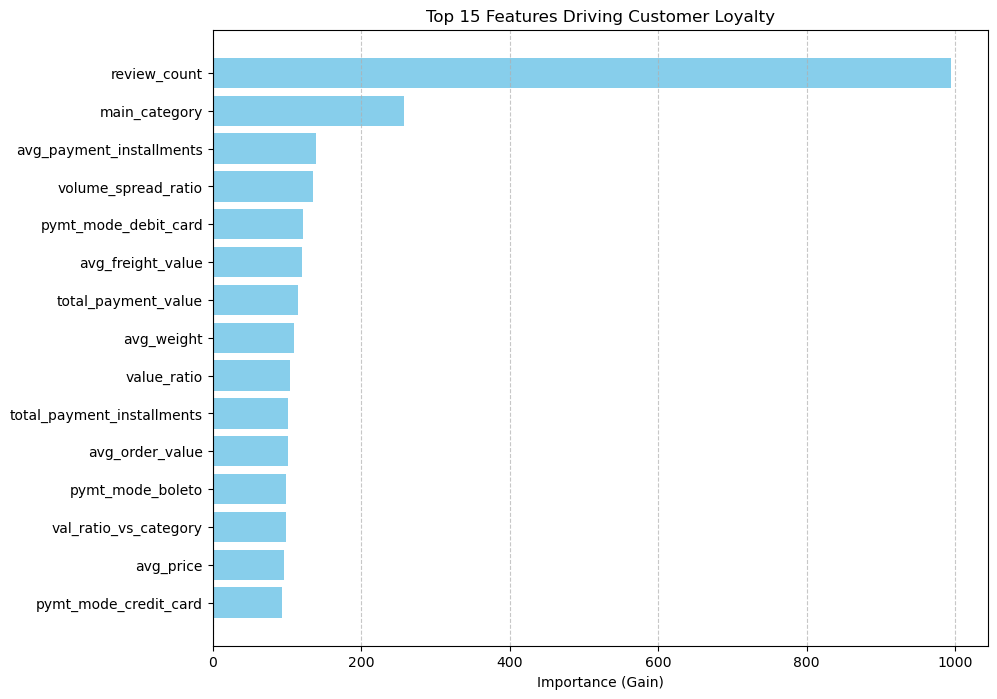

In [349]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Extract importance (using Gain)
importance = model.get_booster().get_score(importance_type='gain')

# 2. Convert to a sorted DataFrame
importance_df = pd.DataFrame({
    'Feature': importance.keys(),
    'Importance': importance.values()
}).sort_values(by='Importance', ascending=False)

# 3. Plot the Top 15 features
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].head(15), importance_df['Importance'].head(15), color='skyblue')
plt.xlabel('Importance (Gain)')
plt.title('Top 15 Features Driving Customer Loyalty')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [352]:
# --- STEP 1: Train LightGBM (Standard/Balanced) ---
lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    is_unbalance=True,      # This is LGBM's way of handling the imbalance
    objective='binary',
    metric='auc',           # Helps it stay stable during training
    importance_type='gain',
    random_state=42,
    verbosity=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# --- STEP 2: Get Predictions (Ensure you use Focal XGB) ---
# Use the model_focal we just built!
xgb_focal_probs = model_focal.predict_proba(X_test)[:, 1] 
lgb_probs = lgb_model.predict_proba(X_test)[:, 1]

# --- STEP 3: Ensemble ---
# Try a 60/40 split favoring the Focal Loss model, which is better at "hard" cases
ensemble_probs = (0.6 * xgb_focal_probs) + (0.4 * lgb_probs)

# --- STEP 4: Evaluate ---
from sklearn.metrics import average_precision_score

print(f"Focal XGBoost PR-AUC: {average_precision_score(y_test, xgb_focal_probs):.4f}")
print(f"LightGBM PR-AUC:     {average_precision_score(y_test, lgb_probs):.4f}")
print(f"Ensemble PR-AUC:      {average_precision_score(y_test, ensemble_probs):.4f}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's auc: 0.612786
Focal XGBoost PR-AUC: 0.0621
LightGBM PR-AUC:     0.0681
Ensemble PR-AUC:      0.0695


In [351]:
import numpy as np

def focal_loss_objective(y_true, y_pred, gamma=2.0, alpha=0.25):
    # Convert margin to probability
    preds = 1.0 / (1.0 + np.exp(-y_pred))
    
    # Gradient and Hessian calculations
    pos_factor = alpha * (1 - preds)**gamma
    neg_factor = (1 - alpha) * preds**gamma
    
    grad = y_true * pos_factor * (preds - 1) + (1 - y_true) * neg_factor * preds
    
    # Simplified Hessian for training stability
    hess = y_true * pos_factor * preds * (1 - preds) + (1 - y_true) * neg_factor * preds * (1 - preds)
    
    return grad, hess

# Training with Focal Loss
model_focal = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    tree_method='hist',
    early_stopping_rounds=50
)

# Pass the custom function to the 'objective' parameter
model_focal.set_params(objective=focal_loss_objective)

model_focal.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",<function foc...t 0x34f7860c0>
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import loa

In [354]:
from scipy.stats import rankdata

# Convert probabilities to ranks (0.0 to 1.0 scale)
xgb_rank = rankdata(xgb_focal_probs) / len(xgb_focal_probs)
lgb_rank = rankdata(lgb_probs) / len(lgb_probs)

# Blend the ranks
rank_ensemble = (0.6 * xgb_rank) + (0.4 * lgb_rank)

# Check the score
from sklearn.metrics import average_precision_score
print(f"Rank-Based Ensemble PR-AUC: {average_precision_score(y_test, rank_ensemble):.4f}")

Rank-Based Ensemble PR-AUC: 0.0704


In [355]:
import pandas as pd

# 1. Create a results dataframe
results = pd.DataFrame({
    'actual': y_test,
    'prob': rank_ensemble
})

# 2. Divide into 10 equal groups (Deciles)
results['decile'] = pd.qcut(results['prob'], 10, labels=False, duplicates='drop')

# 3. Calculate the hit rate (loyalty rate) per decile
lift_df = results.groupby('decile')['actual'].mean().reset_index()
lift_df = lift_df.sort_values('decile', ascending=False) # Top decile first
lift_df['lift'] = lift_df['actual'] / y_test.mean()

print("--- Lift per Decile ---")
print(lift_df[['decile', 'actual', 'lift']])

--- Lift per Decile ---
   decile    actual      lift
9       9  0.023170  2.147246
8       8  0.012099  1.121243
7       7  0.007895  0.731630
6       6  0.012112  1.122424
5       5  0.006316  0.585304
4       4  0.011579  1.073058
3       3  0.012638  1.171225
2       2  0.007895  0.731630
1       1  0.005789  0.536529
0       0  0.008421  0.780406


In [356]:
X_train

,customer_zip_code_prefix,tot_customers_in_zip,tot_sellers_in_zip,n_distinct_categories,main_category,avg_photos_per_product,avg_desc_length,avg_weight,avg_volume,total_price,avg_price,total_freight_value,avg_freight_value,total_order_value,avg_order_value,total_items,min_items,max_items,review_count,avg_review_score,has_review_text,pymt_mode_boleto,pymt_mode_credit_card,pymt_mode_debit_card,pymt_mode_not_defined,pymt_mode_voucher,avg_payment_installments,total_payment_installments,total_payment_value,sentiment_index,state_avg,cat_avg,value_ratio,val_ratio_vs_category,freight_ordervalue_ratio,price_spread_ratio,order_value_spread_ratio,weight_spread_ratio,volume_spread_ratio
2,88115,7.0,1.0,1.0,0.026410,3.0,177.0,1500.0,43750.0,69.00,69.00,17.22,17.22,86.22,86.22,1.0,1.0,1.0,1.0,3.0,0.0,0.0,86.22,0.0,0.0,0.0,8.0,8.0,86.22,2,164.244218,121.416330,0.524950,0.710119,0.199722,1.000000,1.000000,1.000000,1.000000
3,66812,7.0,0.0,1.0,0.029246,5.0,1741.0,150.0,1045.0,25.99,25.99,17.63,17.63,43.62,43.62,1.0,1.0,1.0,1.0,4.0,1.0,0.0,43.62,0.0,0.0,0.0,4.0,4.0,43.62,5,221.099439,82.899088,0.197287,0.526182,0.404172,1.000000,1.000000,1.000000,1.000000
4,18040,14.0,3.0,1.0,0.029246,3.0,794.0,6050.0,528.0,180.00,180.00,16.89,16.89,196.89,196.89,1.0,1.0,1.0,1.0,5.0,0.0,0.0,196.89,0.0,0.0,0.0,6.0,6.0,196.89,4,143.654734,82.899088,1.370578,2.375056,0.085784,1.000000,1.000000,1.000000,1.000000
7,80410,10.0,1.0,1.0,0.049468,1.0,190.0,1133.5,15059.0,382.00,191.00,37.18,18.59,419.18,209.59,2.0,1.0,1.0,1.0,1.0,1.0,0.0,419.18,0.0,0.0,0.0,3.0,3.0,419.18,0,160.206133,150.496243,2.616504,2.785319,0.088697,1.000000,1.000000,1.036612,1.139518
8,25966,3.0,0.0,1.0,0.070698,6.0,1118.0,2250.0,6600.0,135.00,135.00,15.12,15.12,150.12,150.12,1.0,1.0,1.0,1.0,4.0,0.0,0.0,150.12,0.0,0.0,0.0,3.0,3.0,150.12,4,166.934710,99.585188,0.899274,1.507453,0.100719,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94983,60055,8.0,0.0,0.0,0.031429,NaN,NaN,350.0,704.0,149.00,149.00,18.32,18.32,167.32,167.32,1.0,1.0,1.0,1.0,5.0,0.0,0.0,167.32,0.0,0.0,0.0,2.0,2.0,167.32,4,204.510406,150.608223,0.818149,1.110962,0.109491,1.000000,1.000000,1.000000,1.000000
94985,55250,3.0,0.0,1.0,0.041834,1.0,478.5,30000.0,251625.0,1570.00,785.00,497.42,248.71,2067.42,1033.71,2.0,1.0,1.0,1.0,5.0,0.0,0.0,2067.42,0.0,0.0,0.0,10.0,10.0,2067.42,4,193.713582,161.982531,10.672561,12.763228,0.240599,1.308824,1.249298,1.000000,1.000000
94986,44054,7.0,0.0,1.0,0.031511,2.0,506.0,1720.0,32076.0,64.89,64.89,19.69,19.69,84.58,84.58,1.0,1.0,1.0,1.0,4.0,0.0,0.0,84.58,0.0,0.0,0.0,1.0,1.0,84.58,4,178.823851,177.471936,0.472979,0.476582,0.232797,1.000000,1.000000,1.000000,1.000000
94987,78552,7.0,1.0,1.0,0.028851,5.0,716.0,600.0,3315.0,89.90,89.90,22.56,22.56,112.46,112.46,1.0,1.0,1.0,1.0,5.0,0.0,0.0,112.46,0.0,0.0,0.0,1.0,1.0,112.46,4,207.178167,180.535998,0.542818,0.622923,0.200605,1.000000,1.000000,1.000000,1.000000
